# **Movie Genre Classification using TF-IDF and Naive Bayes** #
Aim is to build a machine learning model to predict the genre of a movie based on its plot summary or textual information. To achieve this, we will leverage natural language processing (NLP) techniques, specifically TF-IDF (Term Frequency-Inverse Document Frequency), in conjunction with the Naive Bayes classification algorithm.

The primary goal is to create a model that can automatically assign one or more genres to a movie based on the textual description provided. This can be valuable for categorizing and organizing movies in databases, recommendation systems, and content filtering.

# Importing Libraries #

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Load Dataset #

In [2]:
train_data = pd.read_csv("../data/train.csv")

In [3]:
print(train_data.describe())

                 ID
count  54214.000000
mean   27107.500000
std    15650.378084
min        1.000000
25%    13554.250000
50%    27107.500000
75%    40660.750000
max    54214.000000


In [4]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54214 non-null  int64 
 1   TITLE        54214 non-null  object
 2   GENRE        54214 non-null  object
 3   DESCRIPTION  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB
None


In [5]:
print(train_data.isnull().sum())

ID             0
TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64


In [6]:
# Load the test data
test_data = pd.read_csv("../data/test.csv")
test_data.head()

,ID,TITLE,DESCRIPTION
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apart..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty chi..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family o...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with his..."
4,5,Er nu zhai (1955),Before he was known internationally as a marti...


# EDA & Visualization #

/var/folders/r7/jwzdkh1512v2b1_q9q4ky_6c0000gn/T/ipykernel_10282/3791479286.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, y='GENRE', order=train_data['GENRE'].value_counts().index, palette='viridis')
/Users/kausik/.local/share/virtualenvs/CodSoft-Dx2vzRgQ/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/kausik/.local/share/virtualenvs/CodSoft-Dx2vzRgQ/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `

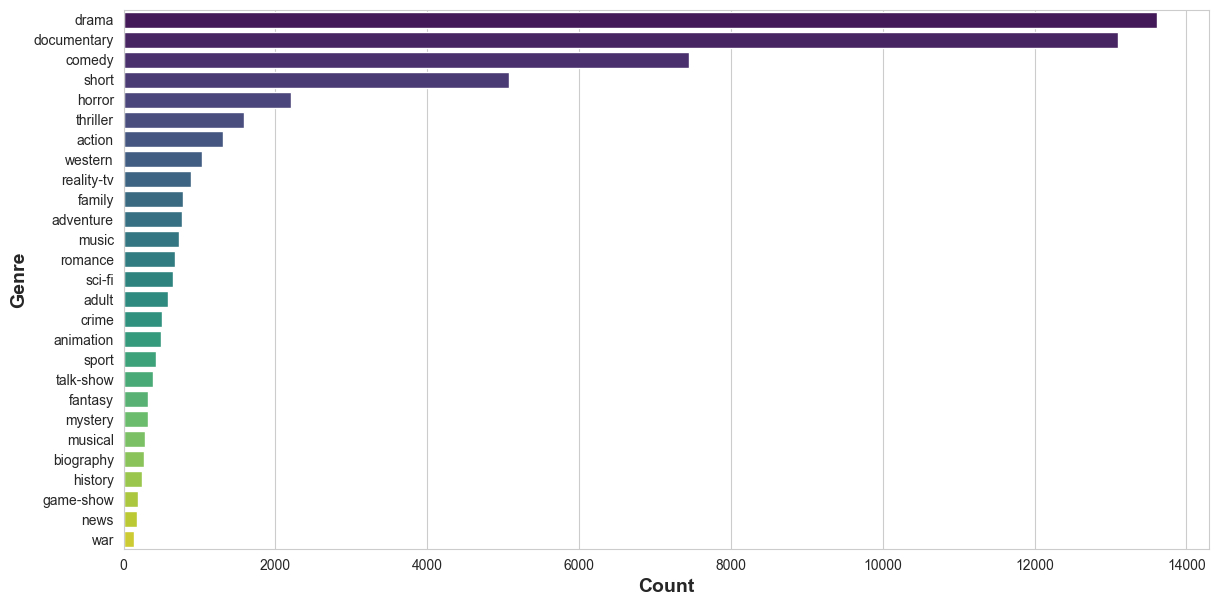

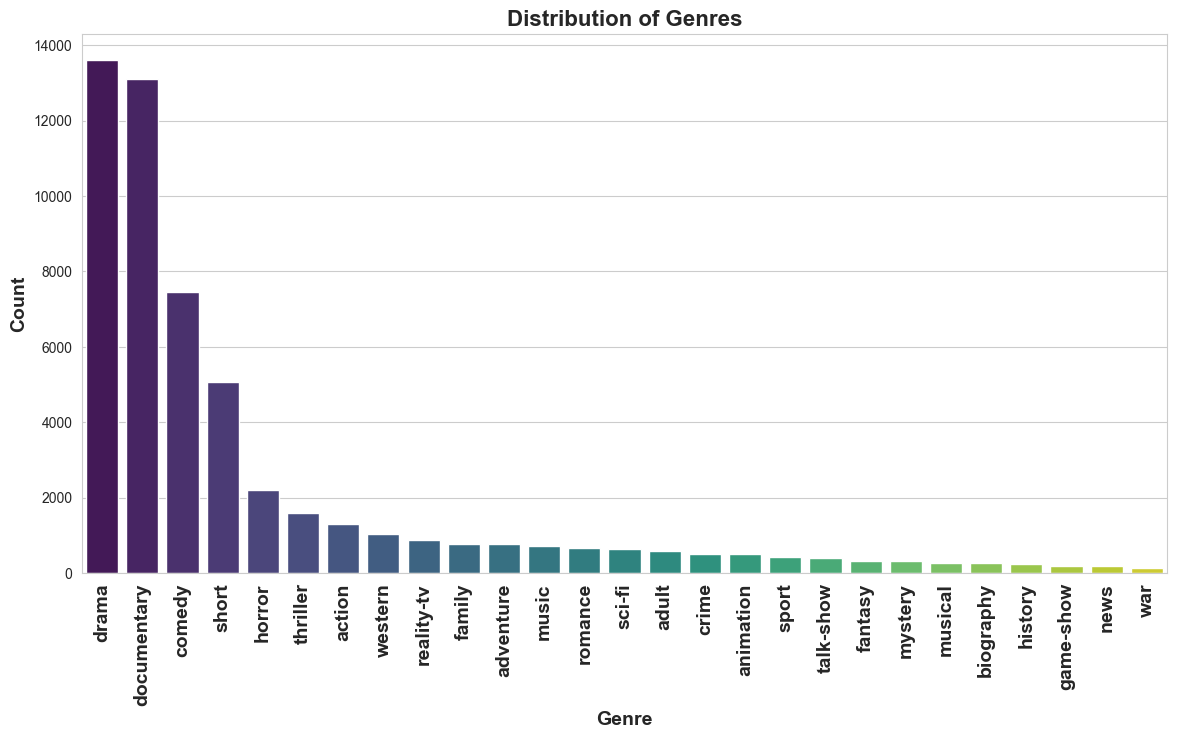

In [7]:
# Plot the distribution of genres in the training data
plt.figure(figsize=(14, 7))
sns.countplot(data=train_data, y='GENRE', order=train_data['GENRE'].value_counts().index, palette='viridis')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Genre', fontsize=14, fontweight='bold')

# Plot the distribution of genres using a bar plot
plt.figure(figsize=(14, 7))
counts = train_data['GENRE'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='viridis')
plt.xlabel('Genre', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Genres', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()


#  Data Preprocessing and Text Cleaning #

In [8]:
# Initialize the stemmer and stop words
# In the earlier Email Classifier we used PorterStemmer to stem the text
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
train_data['Text_cleaning'] = train_data['DESCRIPTION'].apply(clean_text)
test_data['Text_cleaning'] = test_data['DESCRIPTION'].apply(clean_text)


# Visualising Data After Preprocessing #

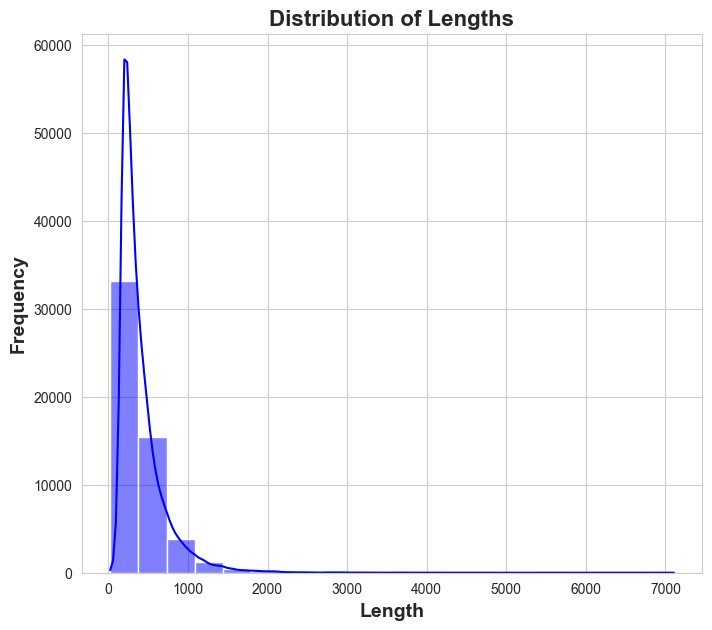

In [9]:
# Calculate the length of cleaned text
train_data['length_Text_cleaning'] = train_data['Text_cleaning'].apply(len)
# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()


#  Text Vectorization Using TF-IDF #

In [14]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])

# Transform the test data
X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])


#  Split Data and Train a Model (Naive Bayes) #

In [15]:
# Split the data into training and validation sets
X = X_train
y = train_data['GENRE']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = classifier.predict(X_val)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))


Validation Accuracy: 0.5225491100249009
              precision    recall  f1-score   support

      action       0.56      0.08      0.15       263
       adult       1.00      0.06      0.12       112
   adventure       0.40      0.04      0.08       139
   animation       0.00      0.00      0.00       104
   biography       0.00      0.00      0.00        61
      comedy       0.51      0.43      0.47      1443
       crime       0.00      0.00      0.00       107
 documentary       0.58      0.88      0.70      2659
       drama       0.46      0.83      0.59      2697
      family       1.00      0.01      0.01       150
     fantasy       0.00      0.00      0.00        74
   game-show       1.00      0.15      0.26        40
     history       0.00      0.00      0.00        45
      horror       0.74      0.37      0.49       431
       music       0.80      0.11      0.20       144
     musical       0.00      0.00      0.00        50
     mystery       0.00      0.00      0.

/Users/kausik/.local/share/virtualenvs/CodSoft-Dx2vzRgQ/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kausik/.local/share/virtualenvs/CodSoft-Dx2vzRgQ/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kausik/.local/share/virtualenvs/CodSoft-Dx2vzRgQ/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

 # Make Predictions on the Test Data #

In [16]:
# Use the trained model to make predictions on the test data
X_test_predictions = classifier.predict(X_test)
test_data['Predicted_Genre'] = X_test_predictions

In [17]:
# Save the test_data DataFrame with predicted genres to a CSV file
test_data.to_csv('predicted_genres.csv', index=False)

# Display the 'test_data' DataFrame with predicted genres
print(test_data)


          ID                           TITLE  \
0          1            Edgar's Lunch (1998)   
1          2        La guerra de papá (1977)   
2          3     Off the Beaten Track (2010)   
3          4          Meu Amigo Hindu (2015)   
4          5               Er nu zhai (1955)   
...      ...                             ...   
54195  54196  "Tales of Light & Dark" (2013)   
54196  54197     Der letzte Mohikaner (1965)   
54197  54198             Oliver Twink (2007)   
54198  54199               Slipstream (1973)   
54199  54200       Curitiba Zero Grau (2010)   

                                             DESCRIPTION  \
0      L.R. Brane loves his life - his car, his apart...   
1      Spain, March 1964: Quico is a very naughty chi...   
2      One year in the life of Albin and his family o...   
3      His father has died, he hasn't spoken with his...   
4      Before he was known internationally as a marti...   
...                                                  ...   
541

In [18]:
import joblib
joblib.dump(classifier, 'final_model.pkl')
joblib.dump(tfidf_vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

# Using GridSearchCV to find the best parameters

In [14]:
# Deleting the previous variables
del X_test
del X_train
del y_train
del y_val
del y 
del classifier
del tfidf_vectorizer

In [15]:
X = train_data["Text_cleaning"]
y = train_data['GENRE']

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# GLOBAL OPTIMISATION

Let's find the best parameters for the model so as to minimise the error and also prevent overfitting.

Here's how we prevent Overfitting:

GridSearchCV performs cross-validation internally, which helps to prevent overfitting. Cross-validation is a technique where the **training set is split into multiple smaller sets**, or **"folds"**. The model is then trained on all but one of these folds and validated on the remaining fold. This process is repeated for each fold, so every data point gets to be in the validation set exactly once. This helps to ensure that the model generalizes well to unseen data.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearnex import patch_sklearn

patch_sklearn() 
# I'm using an Intel based computer, so we are patching sklearn to work according with the underlying Intel Infrastructure

# Define the parameter grid
param_grid = {
    'clf__alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
    'clf__fit_prior': [True, False],
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 2],
    'tfidf__max_features': [None, 5000, 10000, 50000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)]  
    # unigrams or bigrams
}

# Initialize the Tfidf Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Initialize the MultinomialNB
classifier = MultinomialNB()

# Create a pipeline
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('clf', classifier)
])

# Initialize the GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=5)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Use the best estimator to make predictions
best_classifier = grid_search.best_estimator_

# Make predictions on the validation set
y_pred = best_classifier.predict(X_val)

# Convert the cv_results_ to a DataFrame
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
print(cv_results_df)

In [ ]:
# Plot the results of the grid search
plt.figure(figsize=(14, 7))
sns.lineplot(data=cv_results_df, x='param_clf__alpha', y='mean_test_score', hue='param_clf__fit_prior', palette='viridis')
plt.xlabel('Alpha', fontsize=14, fontweight='bold')
plt.ylabel('Mean Test Score', fontsize=14, fontweight='bold')
plt.title('Grid Search Results', fontsize=16, fontweight='bold')
plt.show()

In [ ]:
cv_results_df.to_csv('cv_results.csv')

In [ ]:
# Save the best model
import joblib
joblib.dump(best_classifier, 'best_model.pkl')


In [ ]:
# Print the best parameters
print("Best parameters: ", grid_search.best_params_)